In [33]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from gvit.quadtree import QuadTree

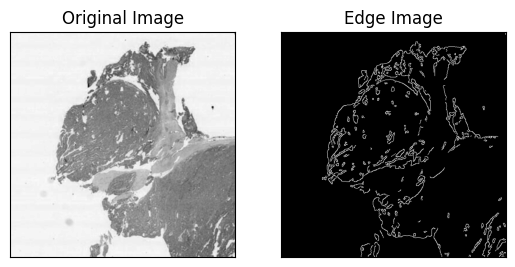

In [34]:
img = cv.imread('./dataset/exp/pathology/piap.jpeg')
grey_img = img[0:512,0:512, 0]
grey_img = cv.GaussianBlur(grey_img, (3,3),0)
edges = cv.Canny(grey_img, 100, 200)

plt.subplot(121),plt.imshow(grey_img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.savefig(fname="paip_canny.jpg")
plt.show()

In [35]:
print(grey_img.shape)

(512, 512)


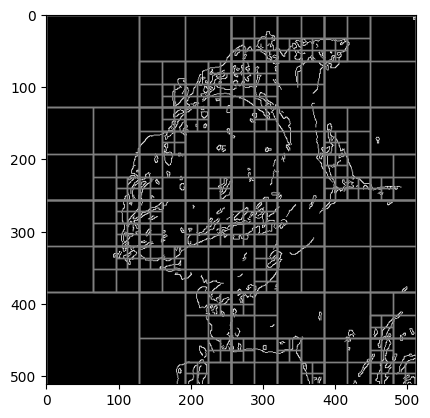

In [36]:
fig, ax = plt.subplots()
ax.imshow(edges, cmap = 'gray')

qdt = QuadTree(domain=edges)
qdt.draw(ax=ax)
plt.savefig(fname="paip_pachify.jpg")
plt.show()

In [37]:
# 8x8 => 424 patches
# 512/8 = 64*64 => 4096 patches  

patch_info = {}
print(qdt.count_patches(patch_info))
print(patch_info)
print(sum(patch_info.values()))


322
{'128*128': 2, '64*64': 19, '16*16': 204, '32*32': 97}
322


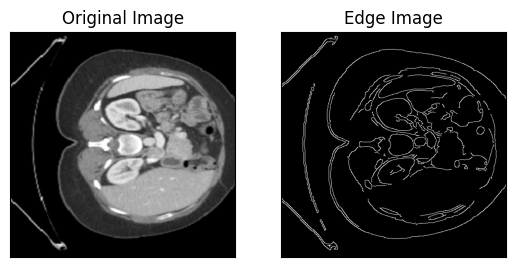

In [38]:
img = cv.imread('./dataset/exp/btcv/organs.jpeg')
grey_img = img[:, :, 0]
grey_img = cv.resize(grey_img, dsize=(512, 512), interpolation=cv.INTER_CUBIC)
grey_img = cv.GaussianBlur(grey_img, (3,3), 0)
edges = cv.Canny(grey_img, 100, 200)

plt.subplot(121),plt.imshow(grey_img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.savefig(fname="paip_canny.jpg")
plt.show()

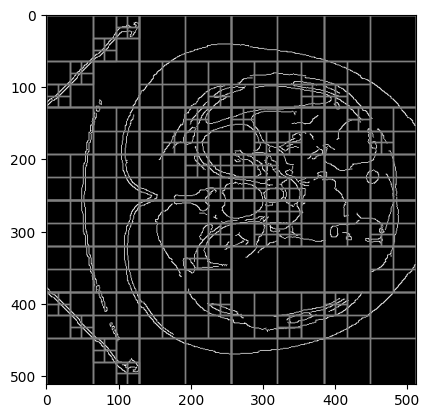

In [41]:
fig, ax = plt.subplots()
ax.imshow(edges, cmap = 'gray')

qdt = QuadTree(domain=edges, max_value=80)
qdt.draw(ax=ax)
plt.savefig(fname="paip_pachify.jpg")
plt.show()

In [42]:
# 8x8 => 1036 patches
# 512/8 = 64*64 => 4096 patches  

patch_info = {}
print(qdt.count_patches(patch_info))
print(patch_info)
print(sum(patch_info.values()))

304
{'64*64': 21, '32*32': 135, '16*16': 148}
304


In [10]:
#imagenet patchify

import torch
import torchvision
from torchvision import transforms

datapath = './dataset'
def imagenet(datapath=datapath):

    train_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor()  
        ])

    imagenet_data = torchvision.datasets.ImageNet('./dataset', transform= train_transform)
    imagenet_val = torchvision.datasets.ImageNet('./dataset', split="val", transform= train_transform)
    print("train samples:{}, val_samples:{}".format(len(imagenet_data), len(imagenet_val)))
    
    train_loader = torch.utils.data.DataLoader(imagenet_data,
                                            batch_size=4,
                                            shuffle=True,
                                            num_workers=64)
    val_loader = torch.utils.data.DataLoader(imagenet_val,
                                        batch_size=4,
                                        shuffle=True,
                                        num_workers=64)
    
    train_dataset = iter(train_loader)
    val_dataset = iter(val_loader)
    return train_dataset, val_loader

train_ds,val_ds = imagenet()

train samples:1281167, val_samples:50000


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 48, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# custom dataset patchify
import torch
import torchvision
from torchvision import transforms

datapath = './dataset/exp/'
def custom_dataset(datapath=datapath):

    train_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor()  
        ])

    image_train = torchvision.datasets.ImageFolder(datapath, transform= train_transform)
    image_val = torchvision.datasets.ImageFolder(datapath, transform= train_transform)
    print("train samples:{}, val_samples:{}".format(len(image_train), len(image_val)))
    
    train_loader = torch.utils.data.DataLoader(image_train,
                                            batch_size=4,
                                            shuffle=True,
                                            num_workers=64)
    val_loader = torch.utils.data.DataLoader(image_val,
                                        batch_size=4,
                                        shuffle=True,
                                        num_workers=64)
    
    train_dataset = iter(train_loader)
    val_dataset = iter(val_loader)
    return train_dataset, val_dataset

train_ds, val_ds = custom_dataset()
for (i,data) in enumerate(train_ds):
    print(data[0].shape, data[1])

train samples:4, val_samples:4
torch.Size([4, 3, 256, 256]) tensor([1, 2, 3, 0])


In [24]:
import os 
import glob 
from pathlib import Path

# patchify
 
def get_img_path(base="./dataset/exp/"):
    files = []
    for f in glob.glob(os.path.join(base, "*/*.jpeg")):
        files.append(f)
    return files

def transform(img):
    res = cv.resize(img, dsize=(512, 512), interpolation=cv.INTER_CUBIC)
    grey_img = res[:, :, 0]
    blur = cv.GaussianBlur(grey_img, (3,3),0)
    edge = cv.Canny(blur, 100, 200)
    return res, edge

# save patch sequence
def compress_mix_patches(qdt:QuadTree, img: np.array, to_size:tuple = (8,8,3)):
    h2,w2,c2 = to_size
    seq_patches = qdt.serialize(img)
    for i in range(len(seq_patches)):
        h1, w1, c1 = seq_patches[i].shape
        assert h1==w1, "Need squared input."
        # print(seq_patches[i].shape, seq_patches[i])
        step =int(h1/to_size[0])
        seq_patches[i] = seq_patches[i][::step,::step]
        assert seq_patches[i].shape == (h2,w2,c2), "Wrong shape {} get, need {}".format(seq_patches[i].shape, (h2,w2,c2))
    return seq_patches

def custom_patchify(base="./dataset/exp", to_size: tuple=(8,8,3)):
    img_path = get_img_path(base=base)
    patch_size = to_size[0]
    save_to = base+"_qdt"
    if not os.path.exists(save_to):
        os.makedirs(save_to)
        
    for i,p in enumerate(img_path):
        img = cv.imread(p)
        img, edge = transform(img)
        qdt = QuadTree(domain=edge)
        seq_patches = compress_mix_patches(qdt, img, to_size)
        seq_img = np.asarray(seq_patches)
        seq_img = np.reshape(seq_img,(patch_size, -1, 3))
        name = Path(p).parts[-2]
        cv.imwrite(save_to+"/{}_{}.jpeg".format(i, name), seq_img)

custom_patchify()
        

In [5]:
def bin(a="11",b="1"):
    c = 0
    i = len(a)-1
    j = len(b)-1
    if i<j:
        a = "0"*(j-i) + a
        i = j
    if i>j:
        b = "0"*(i-j) + b
        j=i
    s = ""
    while i!=-1 and j!=-1:
        if a[i]=="1" and b[j]=="1":
            if c == 1:
                s = "1"+ s
                c = 1
            else:
                s = "0"+ s
                c = 1
        if a[i]!="1" and b[j]=="1":
            if c == 1:
                s = "0"+s
                c = 1
            else:
                s = "1"+s
                c = 0
        if a[i]=="1" and b[j]!="1":
            if c == 1:
                s = "0"+s
                c = 1
            else:
                s = "1"+s
                c = 0
        if a[i]!="1" and b[j]!="1":
            if c == 1:
                s = "1"+s
                c = 0
            else:
                s = "0"+s
                c = 0
        i-=1
        j-=1
    if c!=0:
        s = "1" + s
    return s
print(bin())

100
